<a href="https://colab.research.google.com/github/InscribeDeeper/bert_utils/blob/master/qa_bert_pingenbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Table of Contents: training with sub dataset<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Baseline-3:-BioBERT-Pretrained---CNN-only" data-toc-modified-id="Baseline-3:-BioBERT-Pretrained---CNN-only-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Baseline 3: BioBERT Pretrained - CNN only</a></span></li><li><span><a href="#1.-Setup" data-toc-modified-id="1.-Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>1. Setup</a></span></li><li><span><a href="#2.-Parse-data" data-toc-modified-id="2.-Parse-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>2. Parse data</a></span></li><li><span><a href="#3.-Tokenization-&amp;-Input-Formatting" data-toc-modified-id="3.-Tokenization-&amp;-Input-Formatting-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>3. Tokenization &amp; Input Formatting</a></span></li><li><span><a href="#4.-Define-model" data-toc-modified-id="4.-Define-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>4. Define model</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#6.1.-Evalution-Function" data-toc-modified-id="6.1.-Evalution-Function-5.0.1"><span class="toc-item-num">5.0.1&nbsp;&nbsp;</span>6.1. Evalution Function</a></span></li></ul></li><li><span><a href="#6.3.-4-fold-cross-validation;-one-vs-the-rest" data-toc-modified-id="6.3.-4-fold-cross-validation;-one-vs-the-rest-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>6.3. 4-fold cross validation; one-vs-the-rest</a></span></li></ul></li><li><span><a href="#7.-Train-a-model-with-all-data-for-prediction" data-toc-modified-id="7.-Train-a-model-with-all-data-for-prediction-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>7. Train a model with all data for prediction</a></span></li><li><span><a href="#Predict-sentences" data-toc-modified-id="Predict-sentences-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Predict sentences</a></span></li></ul></div>

# Baseline 3: BioBERT Pretrained - CNN only

---




In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#pip install --target=$package_path torchinfo

# 1. Setup

In [4]:
import sys, os
# nb_path = '/content/rl'
# #os.symlink('/content/drive/MyDrive/Colab_Notebooks', nb_path)

# package_path = '/content/drive/MyDrive/Colab_Notebooks/packages'
# sys.path.insert(0,nb_path)
# sys.path.insert(0,package_path)

cur_path = os.path.join('/content/drive/MyDrive/Conf_Call/')
print(os.getcwd())
os.chdir(cur_path)

/content


In [5]:
import random, pickle
import numpy as np
from torch.nn import BCEWithLogitsLoss, BCELoss
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score, precision_recall_fscore_support
import tensorflow as tf
import torch
import pandas as pd

!pip install transformers
from transformers import AutoConfig, AutoModel, AutoTokenizer, AutoModelForSequenceClassification

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

!pip install torchinfo
from torchinfo import summary
from sklearn.model_selection import train_test_split, StratifiedKFold

import copy
from sklearn.utils import shuffle
import glob

import time
import datetime



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Dec 29 21:26:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    32W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    device_name ="/cpu:0"
    print('GPU device not found')
    #raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [8]:
# If there's a GPU available...
if torch.cuda.is_available(): 

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [9]:
# set seed
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

Download BioBERT Base Model

# 2. Parse data

We'll use pandas to parse the "in-domain" training set and look at a few of its properties and data points.

In [10]:
# Load the dataset into a pandas dataframe.
df = pd.read_csv("/content/drive/MyDrive/temp/merge_qa_label.csv", encoding="ISO-8859-1")
#df = pd.read_csv("surprise_checking_internal_0905.csv", encoding="ISO-8859-1")
#df = df[df.Negative==0]
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))
df = df.drop(['Unnamed: 0','Unnamed: 2'], axis=1)
# Display 10 random rows from the data.
df.sample(10)

# df = pd.read_excel("/content/drive/MyDrive/temp/surprise_dt_test_v9_all_kiera.xlsx")
# #df = df[df.Negative==0]
# # Report the number of sentences.
# print('Number of training sentences: {:,}\n'.format(df.shape[0]))
# df = df.drop(['Unnamed: 0'], axis=1)
# df = df.rename(columns={'merged':'label'})
# # Display 10 random rows from the data.
# df.sample(10)

Number of training sentences: 1,173



,sentence,label
506,"And you are targeting, it sounds like multiple...",0
220,Unusual to see CN change guidance this early i...,1
1043,And then real briefly on TiO2 feedstock pricin...,0
977,I think you mentioned hundreds of units from o...,0
174,It??s amazing that there is no common period e...,1
584,"And finally, I got to ask Atish what??s the bi...",0
786,"If I was reading the document correctly, it lo...",1
1139,"So, it wouldn??t have been a material contribu...",0
58,I'm wondering why you think we're not seeing i...,1
240,And you referred that the last time you saw th...,0


In [11]:
random.seed(3)

In [12]:
len(df)
#df["label"] =df["label"].fillna(0)
df= df[~df['label'].isna()]

df.label.value_counts()

1173

0    928
1    245
Name: label, dtype: int64

In [13]:
neg = 280
import sklearn
negs = sklearn.utils.shuffle(df[df.label==0].index.tolist())
df = df[(df.label==1) | (df.index.isin(negs[0:neg]))]

df.label.value_counts()

0    280
1    245
Name: label, dtype: int64

In [14]:
df[df.label==0].iloc[0].values

array(['But I??m just wondering how you actually manage that, when you??re looking at your underwriting teams and trying to manage their risks properly around a business that??s growing at such a high rate.',
       0], dtype=object)



Let's extract the sentences and labels of our training set as numpy ndarrays.

In [15]:
df = pd.read_csv('/content/drive/MyDrive/temp/traingsample.csv')

In [16]:
# Get the lists of sentences and their labels.
sentences = df.sentence.values
labels = [0,1]
num_labels = len(labels)
df.label.sum()

245

In [17]:
labels[0:2]
print(len(labels))
print(len(sentences))

[0, 1]

2
525


In [18]:
#df.to_csv('/content/drive/MyDrive/temp/traingsample.csv',index=False)

# 3. Tokenization & Input Formatting

In this section, we'll transform our dataset into the format that BERT can be trained on.


To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with BERT--the below cell will download this for us. We'll be using the "uncased" version here.


In [19]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# tokenizer = AutoTokenizer.from_pretrained('yiyanghkust/finbert-pretrain', do_lower_case=True )
# tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert', do_lower_case=True )


Loading BERT tokenizer...


Let's apply the tokenizer to one sentence just to see the output.


In [20]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  But I??m just wondering how you actually manage that, when you??re looking at your underwriting teams and trying to manage their risks properly around a business that??s growing at such a high rate.
Tokenized:  ['but', 'i', '?', '?', 'm', 'just', 'wondering', 'how', 'you', 'actually', 'manage', 'that', ',', 'when', 'you', '?', '?', 're', 'looking', 'at', 'your', 'under', '##writing', 'teams', 'and', 'trying', 'to', 'manage', 'their', 'risks', 'properly', 'around', 'a', 'business', 'that', '?', '?', 's', 'growing', 'at', 'such', 'a', 'high', 'rate', '.']
Token IDs:  [2021, 1045, 1029, 1029, 1049, 2074, 6603, 2129, 2017, 2941, 6133, 2008, 1010, 2043, 2017, 1029, 1029, 2128, 2559, 2012, 2115, 2104, 18560, 2780, 1998, 2667, 2000, 6133, 2037, 10831, 7919, 2105, 1037, 2449, 2008, 1029, 1029, 1055, 3652, 2012, 2107, 1037, 2152, 3446, 1012]


In [21]:

bert_model = AutoModel.from_pretrained(
    # 'ProsusAI/finbert',
    'bert-base-uncased',
    num_labels = 2, 
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = True, # Whether the model returns all hidden-states.
    )
bert_model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [22]:
# Put everything together as a function. This is for pretrained word vectors

def get_pretrained_wordvector(sentences, tokenizer, bert_model):

    input_ids = []
    attention_masks = []
    max_len =100

    # For every sentence...
    for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        #padding='max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])
    
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])


    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    bert_model.eval()
    with torch.no_grad():

        outputs = bert_model(input_ids.to(device), attention_masks.to(device))   
        hidden_states = outputs[2]

    
    # get the last four layers
    token_embeddings = torch.stack(hidden_states[-4:], dim=0) 
    #print(token_embeddings.size())

    # permute axis
    token_embeddings = token_embeddings.permute(1,2,0,3)
    #print(token_embeddings.size())

    # take the mean of the last 4 layers
    token_embeddings = token_embeddings.mean(axis=2)

    #print(token_embeddings.size())

    return token_embeddings, attention_masks

In [23]:
token_embeddings, masks = get_pretrained_wordvector(sentences, tokenizer, bert_model)
print(masks.size())

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


torch.Size([525, 100])


In [24]:
token_embeddings = token_embeddings.to(device) * masks.unsqueeze(-1).to(device)
print(token_embeddings.size())

torch.Size([525, 100, 768])


# 4. Define model


The model has two layers:
BiLSTM
CNN
Dense Layer

Depending on loss function used, this model can be single-label or multi-label

In [25]:
class cnn(nn.Module):

    # define all the layers used in model
    def __init__(self, emb_dim, seq_len, num_filters, kernel_sizes, num_classes, dropout_rate = 0.5):
      
        super().__init__()
        self.emb_dim = emb_dim
        self.seq_len = seq_len
        
        self.num_filters = num_filters
        self.kernel_sizes = kernel_sizes
        self.num_classes = num_classes

        #self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_index)
        
        self.convs = nn.ModuleList([nn.Conv2d(1,self.num_filters, (f, self.emb_dim)) for f in self.kernel_sizes])
        self.fc = nn.Linear(len(kernel_sizes)*self.num_filters, self.num_classes)

        self.dropout = nn.Dropout(p=dropout_rate)


    def forward(self, x):

        #x, _ = self.lstm(x)  # (N, seq_len, 2*lstm_units)

        x = x.unsqueeze(1)

        #print(x.size())

        x = [F.relu(conv(x).squeeze(-1)) for conv in self.convs]  # output of three conv

        #print(x[0].size())

        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x] # continue with 3 maxpooling

        x = torch.cat(x, 1)  # N, len(filter_sizes)* num_filters
        #print(x.size())

        x = self.dropout(x)  # N, len(filter_sizes)* num_filters

        logit = self.fc(x)  # (N, num_classes)

        return logit

In [26]:
class lstm_cnn(nn.Module):

    # define all the layers used in model
    def __init__(self, emb_dim, seq_len, lstm_units, num_filters, kernel_sizes, num_classes, dropout_rate = 0.5):
      
        super().__init__()
        self.emb_dim = emb_dim
        self.seq_len = seq_len
        self.lstm_units = lstm_units
        self.num_filters = num_filters
        self.kernel_sizes = kernel_sizes
        self.num_classes = num_classes


        #self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_index)
        # input: [1173, 100, 768]
        # self.norm1 = torch.nn.LayerNorm([self.seq_len , self.emb_dim])
        # self.norm1 = nn.BatchNorm1d(seq_len)
        self.lstm = nn.LSTM(emb_dim,
                            lstm_units,
                            num_layers=1,
                            bidirectional=True,
                            batch_first=True)  # 
        
        self.convs = nn.ModuleList([nn.Conv2d(1,self.num_filters, (f, 2*self.lstm_units)) for f in self.kernel_sizes])
        # self.convs = nn.ModuleList([nn.Conv2d(1,self.num_filters, (f, self.lstm_units)) for f in self.kernel_sizes])
        #self.norm2 = nn.BatchNorm1d(len(kernel_sizes)*self.num_filters)
        self.fc = nn.Linear(len(kernel_sizes)*self.num_filters, self.num_classes)
        self.dropout = nn.Dropout(p=dropout_rate)
        


    def forward(self, x):

       # x = self.norm1(x)

        x, _ = self.lstm(x)  # (N, seq_len, 2*lstm_units)

        x = x.unsqueeze(1)

        #print(x.size())

        x = [F.relu(conv(x).squeeze(-1)) for conv in self.convs]  # output of three conv

        #print(x[0].size())

        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x] # continue with 3 maxpooling

        x = torch.cat(x, 1)  # N, len(filter_sizes)* num_filters
        #print(x.size())

        #x = self.norm2(x)

        x = self.dropout(x)  # N, len(filter_sizes)* num_filters

        logit = self.fc(x)  # (N, num_classes)

        return logit

In [27]:
model = cnn(100, 100, 32, [1,2,3], 6)
#summary(model.to(device),(32, 100, 100))
summary(model,(32, 100, 100))

Layer (type:depth-idx)                   Output Shape              Param #
cnn                                      [32, 6]                   --
├─ModuleList: 1-1                        --                        --
│    └─Conv2d: 2-1                       [32, 32, 100, 1]          3,232
│    └─Conv2d: 2-2                       [32, 32, 99, 1]           6,432
│    └─Conv2d: 2-3                       [32, 32, 98, 1]           9,632
├─Dropout: 1-2                           [32, 96]                  --
├─Linear: 1-3                            [32, 6]                   582
Total params: 19,878
Trainable params: 19,878
Non-trainable params: 0
Total mult-adds (M): 60.94
Input size (MB): 1.28
Forward/backward pass size (MB): 2.43
Params size (MB): 0.08
Estimated Total Size (MB): 3.79

#6. **Define a function to train single-label classifier**

The loss function is different from multi-label classifer

Parameters:

* model: model defined
*   num_labels: number of labels
*   label_cols: label names
*   train_dataloader: train data loader
*   validation_dataloader: validation data loader
*   optimizer: optimizer. default is Adam
*   scheduler: adjust learning rate dynamically; default is None.
*   epochs: number of epochs


### 6.1. Evalution Function

In [28]:
def model_eval(model, dataloader, class_weight = None):
  tokenized_texts = []
  true_labels = []
  pred_labels = []

  threshold = 0.5

  total_eval_accuracy = 0
  total_eval_loss = 0

  for batch in validation_dataloader:
    b_input_ids = batch[0].to(device)
    b_labels = batch[1].to(device)

    with torch.no_grad():        

      logits = model(b_input_ids)
      #loss_func = BCELoss()
      #val_loss = loss_func(torch.sigmoid(logits.view(-1,num_labels)),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation

      if class_weight != None:
          pos_weight=torch.tensor(class_weight).to(device)
          loss_func = BCEWithLogitsLoss(pos_weight=pos_weight)
      else:
          loss_func = BCEWithLogitsLoss()

      val_loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation          
            
      total_eval_loss += val_loss.item()
    
      pred_label = torch.sigmoid(logits)   
      b_labels = b_labels.to('cpu').numpy()
      pred_label = pred_label.to('cpu').numpy()
      
      tokenized_texts.append(b_input_ids)
      true_labels.append(b_labels)
      pred_labels.append(pred_label)

    
  # Flatten outputs
  pred_labels = np.vstack(pred_labels)
  true_labels = np.vstack(true_labels)

  avg_val_loss = total_eval_loss / len(dataloader)    

  return tokenized_texts, pred_labels, true_labels,avg_val_loss
        


##6.2. Training Loop

In [29]:
def train_single_label_model(model, num_labels, label_cols, train_dataloader, validation_dataloader, model_path,\
                             optimizer=None, scheduler=None, epochs = 10, \
                             class_weight = None, patience = 5):

    seed_val = 42

    threshold = 0.5
    #model_path = 'best_model.model'  # save the best model

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    training_stats = []
    
    best_score = -0.5
    best_epoch = 0
    cnt = 0

    total_t0 = time.time()

    if optimizer==None:
        optimizer = torch.optim.Adam(model.parameters())


    # For each epoch...
    for epoch_i in range(0, epochs):
        
        # ========================================
        #               Training
        # ========================================
        
        # Perform one full pass over the training set.

        #print("")
        #print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        #print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            #if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
            #    elapsed = format_time(time.time() - t0)
                
                # Report progress.
                #print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader. 
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_labels = batch[1].to(device)
            
            model.zero_grad()        

            logits = model(b_input_ids)
            #print("logits shape: ", b_input_ids.size(), b_labels.size(), logits.shape())
            #loss_func = BCELoss()
            #loss = loss_func(torch.sigmoid(logits.view(-1,num_labels)),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation

            # add class weight
            if class_weight != None:
              pos_weight=torch.tensor(class_weight).to(device)
              loss_func = BCEWithLogitsLoss(pos_weight=pos_weight)
            else:
              loss_func = BCEWithLogitsLoss()

            loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
            
            total_train_loss += loss.item()

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()

            # Update the learning rate.
            if scheduler!=None:
                scheduler.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            
        
        # Measure how long this epoch took.
        #training_time = format_time(time.time() - t0)

        #print("")
        #print("  Average training loss: {0:.2f}".format(avg_train_loss))
        #print("  Training epcoh took: {:}".format(training_time))
            
        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        #print("")
        #print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        tokenized_texts, pred_labels, true_labels,avg_val_loss = model_eval(model, validation_dataloader, class_weight = class_weight)

        pred_bools = np.argmax(pred_labels, axis = 1)
        true_bools = np.argmax(true_labels, axis = 1)
 
        val_f1 = f1_score(true_bools,pred_bools, average = None)*100 
        val_f1 = val_f1[1] # return f1 for  class 1
        val_acc = (pred_bools == true_bools).astype(int).sum()/len(pred_bools)

        #print('Validation Accuracy: {0:.4f}, F1: {1:.4f}, Loss: {2:.4f}'.format(val_f1, val_acc, avg_val_loss))
        #print(classification_report(np.array(true_labels), pred_bools, target_names=label_cols) )
        print("Epoch {0}\t Train Loss: {1:.4f}\t Val Loss {2:.4f}\t Val Acc: {3:.4f}\t Val F1: {4:.4f}".\
          format(epoch_i +1, avg_train_loss, avg_val_loss, val_acc, val_f1))

        # Measure how long the validation run took.
        #validation_time = format_time(time.time() - t0)
        
        #print("  Validation Loss: {0:.2f}".format(val_f1_accuracy))
        #print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': val_f1,
                'Best F1': best_score,
                'Best epoch': best_epoch
                #'Training Time': training_time,
                #'Validation Time': validation_time
            }
        )

        # early stopping
        if val_f1 > best_score:
            best_score = val_f1
            best_epoch = epoch_i + 1
            torch.save(copy.deepcopy(model.state_dict()), model_path)
            print("model saved")
            cnt = 0
        else:
            cnt += 1
            if cnt == patience:
                print("\n")
                print("early stopping at epoch {0}".format(epoch_i+1))

                break


    

    print("")
    #print("Training complete!")

    #print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

    return model, training_stats

## 6.3. 4-fold cross validation; one-vs-the-rest
Train single label classifier using one vs. the rest

In [30]:
sentences = df.sentence.values
print(len(sentences))
#labels = list(df1.one_hot_labels.values)
#num_labels = len(label_cols)

vectors, masks = get_pretrained_wordvector(sentences, tokenizer, bert_model) 
vectors = vectors.to(device) * masks.unsqueeze(-1).to(device)

525


In [31]:
batch_size = 32
emb_dim = vectors.size(-1)
seq_len = vectors.size(1)
num_filters = 64
kernel_sizes = [1, 3, 5]
num_labels = 2
labels = ['0','1']
class_weight = [1.0,2.0]

result = []
label_cols = ['label']

for col in label_cols:
    print("\n------------") 
    print(col)
    print("------------")
    
    y = df[col].astype(int).values

    fold = 0

    skf = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
    
    for train_index, test_index in skf.split(vectors, y): 

        print("\nfold {} \n".format(fold))

        fold += 1
        X_train, X_test = vectors[train_index], vectors[test_index]
        Y_train, Y_test = y[train_index], y[test_index]

        Y_train = pd.get_dummies(Y_train).values
        Y_train = torch.tensor(Y_train)

        Y_test = pd.get_dummies(Y_test).values
        Y_test = torch.tensor(Y_test)

        train_dataset = TensorDataset(X_train, Y_train)
        val_dataset = TensorDataset(X_test, Y_test)

        train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

        validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

        #weight = 10
        #train_sample_weight = np.array([weight if i ==1 else 1 for i in Y_train])
        #test_sample_weight = np.array([weight if i ==1 else 1 for i in Y_test])

        model_name =  "/content/drive/MyDrive/temp/bert_model/model_" + str(fold)
        #model = cnn(emb_dim, seq_len, num_filters, kernel_sizes, num_labels)
        model = lstm_cnn(emb_dim, seq_len, 100, \
                         num_filters, kernel_sizes, num_labels)
        model.to(device)


        model, training_stats = train_single_label_model(model, num_labels, labels, train_dataloader, validation_dataloader, \
                                                         model_path = model_name, class_weight = class_weight,
                                                        optimizer=None, scheduler=None, epochs = 20)
        
        print("load the best model ... ")

        model.load_state_dict(torch.load(model_name))

        # show performance of best model
        model.eval()
        tokenized_texts, pred_labels, true_labels,avg_val_loss = model_eval(model, validation_dataloader, class_weight = class_weight)

        pred_bools = np.argmax(pred_labels, axis = 1)
        true_bools = np.argmax(true_labels, axis = 1)

        p, r, f, _ = precision_recall_fscore_support(true_bools,pred_bools, pos_label = 1)
        #val_f1 = f1_score(true_bools,pred_bools, average = None)*100 
        #val_f1 = val_f1[1] # return f1 for  class 1
        val_acc = (pred_bools == true_bools).astype(int).sum()/len(pred_bools)
   
    
        print('Precision: {0:.4f}, Recall: {1:.4f}, F1: {2:.4f}, Loss: {3:.4f}'.format(p[1], r[1], f[1], avg_val_loss))
        print(classification_report(true_bools, pred_bools) )

        
    
        #p, r, f = train_model(model, X_train, Y_train, train_sample_weight,\
        #                   X_test, Y_test, test_sample_weight, \
        #                   'baseline_models/lstm_cnn/'+col)

        result.append([col, fold, p[1], r[1], f[1], training_stats[-1]["Best epoch"]])




------------
label
------------

fold 0 



lstm_cnn(
  (lstm): LSTM(768, 100, batch_first=True, bidirectional=True)
  (convs): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(1, 200), stride=(1, 1))
    (1): Conv2d(1, 64, kernel_size=(3, 200), stride=(1, 1))
    (2): Conv2d(1, 64, kernel_size=(5, 200), stride=(1, 1))
  )
  (fc): Linear(in_features=192, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Epoch 1	 Train Loss: 0.8359	 Val Loss 0.7895	 Val Acc: 0.7029	 Val F1: 71.7391
model saved
Epoch 2	 Train Loss: 0.7267	 Val Loss 0.6823	 Val Acc: 0.7143	 Val F1: 73.1183
model saved
Epoch 3	 Train Loss: 0.5590	 Val Loss 0.6534	 Val Acc: 0.7429	 Val F1: 71.3376
Epoch 4	 Train Loss: 0.4035	 Val Loss 0.7396	 Val Acc: 0.7657	 Val F1: 73.5484
model saved
Epoch 5	 Train Loss: 0.2382	 Val Loss 0.8303	 Val Acc: 0.7771	 Val F1: 75.4717
model saved
Epoch 6	 Train Loss: 0.1317	 Val Loss 1.2708	 Val Acc: 0.6914	 Val F1: 69.3182
Epoch 7	 Train Loss: 0.1172	 Val Loss 1.3336	 Val Acc: 0.7657	 Val F1: 72.8477
Epoch 8	 Train Loss: 0.0516	 Val Loss 1.2980	 Val Acc: 0.7657	 Val F1: 73.5484
Epoch 9	 Train Loss: 0.0164	 Val Loss 1.5635	 Val Acc: 0.7543	 Val F1: 70.7483
Epoch 10	 Train Loss: 0.0223	 Val Loss 1.9626	 Val Acc: 0.7029	 Val F1: 70.4545


early stopping at epoch 10

load the best model ... 


<All keys matched successfully>

lstm_cnn(
  (lstm): LSTM(768, 100, batch_first=True, bidirectional=True)
  (convs): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(1, 200), stride=(1, 1))
    (1): Conv2d(1, 64, kernel_size=(3, 200), stride=(1, 1))
    (2): Conv2d(1, 64, kernel_size=(5, 200), stride=(1, 1))
  )
  (fc): Linear(in_features=192, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Precision: 0.7692, Recall: 0.7407, F1: 0.7547, Loss: 0.8303
              precision    recall  f1-score   support

           0       0.78      0.81      0.80        94
           1       0.77      0.74      0.75        81

    accuracy                           0.78       175
   macro avg       0.78      0.77      0.78       175
weighted avg       0.78      0.78      0.78       175


fold 1 



lstm_cnn(
  (lstm): LSTM(768, 100, batch_first=True, bidirectional=True)
  (convs): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(1, 200), stride=(1, 1))
    (1): Conv2d(1, 64, kernel_size=(3, 200), stride=(1, 1))
    (2): Conv2d(1, 64, kernel_size=(5, 200), stride=(1, 1))
  )
  (fc): Linear(in_features=192, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Epoch 1	 Train Loss: 0.8161	 Val Loss 0.7753	 Val Acc: 0.6286	 Val F1: 70.0461
model saved
Epoch 2	 Train Loss: 0.6828	 Val Loss 0.7033	 Val Acc: 0.6514	 Val F1: 71.3615
model saved
Epoch 3	 Train Loss: 0.5690	 Val Loss 0.6411	 Val Acc: 0.7314	 Val F1: 75.3927
model saved
Epoch 4	 Train Loss: 0.3852	 Val Loss 0.6921	 Val Acc: 0.7429	 Val F1: 73.3728
Epoch 5	 Train Loss: 0.2219	 Val Loss 1.0842	 Val Acc: 0.6800	 Val F1: 62.1622
Epoch 6	 Train Loss: 0.1103	 Val Loss 1.3720	 Val Acc: 0.7257	 Val F1: 68.0000
Epoch 7	 Train Loss: 0.0297	 Val Loss 1.7587	 Val Acc: 0.7086	 Val F1: 67.0968
Epoch 8	 Train Loss: 0.0179	 Val Loss 1.8494	 Val Acc: 0.7257	 Val F1: 72.0930


early stopping at epoch 8

load the best model ... 


<All keys matched successfully>

lstm_cnn(
  (lstm): LSTM(768, 100, batch_first=True, bidirectional=True)
  (convs): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(1, 200), stride=(1, 1))
    (1): Conv2d(1, 64, kernel_size=(3, 200), stride=(1, 1))
    (2): Conv2d(1, 64, kernel_size=(5, 200), stride=(1, 1))
  )
  (fc): Linear(in_features=192, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Precision: 0.6606, Recall: 0.8780, F1: 0.7539, Loss: 0.6411
              precision    recall  f1-score   support

           0       0.85      0.60      0.70        93
           1       0.66      0.88      0.75        82

    accuracy                           0.73       175
   macro avg       0.75      0.74      0.73       175
weighted avg       0.76      0.73      0.73       175


fold 2 



lstm_cnn(
  (lstm): LSTM(768, 100, batch_first=True, bidirectional=True)
  (convs): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(1, 200), stride=(1, 1))
    (1): Conv2d(1, 64, kernel_size=(3, 200), stride=(1, 1))
    (2): Conv2d(1, 64, kernel_size=(5, 200), stride=(1, 1))
  )
  (fc): Linear(in_features=192, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Epoch 1	 Train Loss: 0.8144	 Val Loss 0.7718	 Val Acc: 0.5029	 Val F1: 64.4898
model saved
Epoch 2	 Train Loss: 0.6610	 Val Loss 0.6321	 Val Acc: 0.7543	 Val F1: 70.3448
model saved
Epoch 3	 Train Loss: 0.4731	 Val Loss 0.5990	 Val Acc: 0.7257	 Val F1: 72.0930
model saved
Epoch 4	 Train Loss: 0.2964	 Val Loss 0.6862	 Val Acc: 0.7371	 Val F1: 70.8861
Epoch 5	 Train Loss: 0.1494	 Val Loss 0.9759	 Val Acc: 0.6914	 Val F1: 63.0137
Epoch 6	 Train Loss: 0.1119	 Val Loss 1.1470	 Val Acc: 0.7143	 Val F1: 62.6866
Epoch 7	 Train Loss: 0.0640	 Val Loss 1.2790	 Val Acc: 0.7143	 Val F1: 65.2778
Epoch 8	 Train Loss: 0.0110	 Val Loss 1.4754	 Val Acc: 0.6971	 Val F1: 61.8705


early stopping at epoch 8

load the best model ... 


<All keys matched successfully>

lstm_cnn(
  (lstm): LSTM(768, 100, batch_first=True, bidirectional=True)
  (convs): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(1, 200), stride=(1, 1))
    (1): Conv2d(1, 64, kernel_size=(3, 200), stride=(1, 1))
    (2): Conv2d(1, 64, kernel_size=(5, 200), stride=(1, 1))
  )
  (fc): Linear(in_features=192, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Precision: 0.6889, Recall: 0.7561, F1: 0.7209, Loss: 0.5990
              precision    recall  f1-score   support

           0       0.76      0.70      0.73        93
           1       0.69      0.76      0.72        82

    accuracy                           0.73       175
   macro avg       0.73      0.73      0.73       175
weighted avg       0.73      0.73      0.73       175



In [32]:
result_df = pd.DataFrame(result, columns =["label","fold","precision","recall","f1","epoch"])

for col in label_cols:
    print(col)
    print(result_df[result_df.label == col][["precision","recall","f1","epoch"]])
    print(" ")
print(result_df[["label","precision","recall","f1","epoch"]].groupby("label").mean())

label
   precision    recall        f1  epoch
0   0.769231  0.740741  0.754717      5
1   0.660550  0.878049  0.753927      3
2   0.688889  0.756098  0.720930      3
 
       precision    recall        f1     epoch
label                                         
label   0.706223  0.791629  0.743191  3.666667


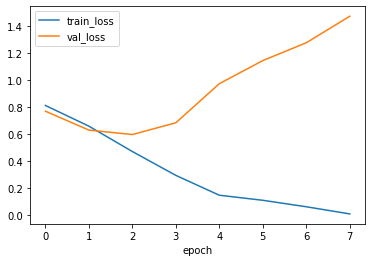

In [33]:
from matplotlib import pyplot as plt
loss = [[i, item['Training Loss'], item['Valid. Loss']] for i, item in enumerate(training_stats)]
acc = [[item["Best epoch"], 'Valid. Accur.'] for item in training_stats]

pd.DataFrame(loss, columns=["epoch", "train_loss","val_loss"]).set_index("epoch").plot(kind="line")
plt.show()

In [34]:
sentences = df.sentence.values
print(len(sentences))
#labels = list(df1.one_hot_labels.values)
#num_labels = len(label_cols)

vectors, masks = get_pretrained_wordvector(sentences, tokenizer, bert_model) 
vectors =  vectors.to(device) * masks.unsqueeze(-1).to(device)

525


In [35]:
# use our labeled data

batch_size = 32
emb_dim = vectors.size(-1)
seq_len = vectors.size(1)
num_filters = 64
kernel_sizes = [1, 3, 5]
num_labels = 2
labels = ['0','1']
class_weight = [1.0,1.0]

result = []
label_cols = ['label']

for col in label_cols:
    print("\n------------") 
    print(col)
    print("------------")
    
    y = df[col].astype(int).values

    fold = 0

    skf = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)
    
    for train_index, test_index in skf.split(vectors, y): 

        print("\nfold {} \n".format(fold))

        fold += 1
        X_train, X_test = vectors[train_index], vectors[test_index]
        Y_train, Y_test = y[train_index], y[test_index]

        Y_train = pd.get_dummies(Y_train).values
        Y_train = torch.tensor(Y_train)

        Y_test = pd.get_dummies(Y_test).values
        Y_test = torch.tensor(Y_test)

        train_dataset = TensorDataset(X_train, Y_train)
        val_dataset = TensorDataset(X_test, Y_test)

        train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

        validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

        #weight = 10
        #train_sample_weight = np.array([weight if i ==1 else 1 for i in Y_train])
        #test_sample_weight = np.array([weight if i ==1 else 1 for i in Y_test])

        model_name = "/content/drive/MyDrive/temp/bert_model/model_" + str(fold)
        #model = cnn(emb_dim, seq_len, num_filters, kernel_sizes, num_labels)
        model = lstm_cnn(emb_dim, seq_len, 100, \
                         num_filters, kernel_sizes, num_labels)
        model.to(device)


        model, training_stats = train_single_label_model(model, num_labels, labels, train_dataloader, validation_dataloader, \
                                                         model_path = model_name, class_weight = class_weight,
                                                        optimizer=None, scheduler=None, epochs = 20)
        
        print("load the best model ... ")

        model.load_state_dict(torch.load(model_name))

        # show performance of best model
        model.eval()
        tokenized_texts, pred_labels, true_labels,avg_val_loss = model_eval(model, validation_dataloader, class_weight = class_weight)

        pred_bools = np.argmax(pred_labels, axis = 1)
        true_bools = np.argmax(true_labels, axis = 1)

        p, r, f, _ = precision_recall_fscore_support(true_bools,pred_bools, pos_label = 1)
        #val_f1 = f1_score(true_bools,pred_bools, average = None)*100 
        #val_f1 = val_f1[1] # return f1 for  class 1
        val_acc = (pred_bools == true_bools).astype(int).sum()/len(pred_bools)
   
    
        print('Precision: {0:.4f}, Recall: {1:.4f}, F1: {2:.4f}, Loss: {3:.4f}'.format(p[1], r[1], f[1], avg_val_loss))
        print(classification_report(true_bools, pred_bools) )

        
    
        #p, r, f = train_model(model, X_train, Y_train, train_sample_weight,\
        #                   X_test, Y_test, test_sample_weight, \
        #                   'baseline_models/lstm_cnn/'+col)

        result.append([col, fold, p[1], r[1], f[1], training_stats[-1]["Best epoch"]])


------------
label
------------

fold 0 



lstm_cnn(
  (lstm): LSTM(768, 100, batch_first=True, bidirectional=True)
  (convs): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(1, 200), stride=(1, 1))
    (1): Conv2d(1, 64, kernel_size=(3, 200), stride=(1, 1))
    (2): Conv2d(1, 64, kernel_size=(5, 200), stride=(1, 1))
  )
  (fc): Linear(in_features=192, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Epoch 1	 Train Loss: 0.6835	 Val Loss 0.6512	 Val Acc: 0.6457	 Val F1: 62.6506
model saved
Epoch 2	 Train Loss: 0.5491	 Val Loss 0.5558	 Val Acc: 0.7371	 Val F1: 65.1515
model saved
Epoch 3	 Train Loss: 0.4311	 Val Loss 0.6159	 Val Acc: 0.7143	 Val F1: 63.7681
Epoch 4	 Train Loss: 0.2829	 Val Loss 0.6839	 Val Acc: 0.7086	 Val F1: 66.6667
model saved
Epoch 5	 Train Loss: 0.1481	 Val Loss 0.8445	 Val Acc: 0.7200	 Val F1: 65.7343
Epoch 6	 Train Loss: 0.0728	 Val Loss 1.0153	 Val Acc: 0.7143	 Val F1: 65.7534
Epoch 7	 Train Loss: 0.0167	 Val Loss 1.2825	 Val Acc: 0.6743	 Val F1: 65.8683
Epoch 8	 Train Loss: 0.0049	 Val Loss 1.6906	 Val Acc: 0.6514	 Val F1: 66.2983
Epoch 9	 Train Loss: 0.0027	 Val Loss 1.7501	 Val Acc: 0.6743	 Val F1: 66.2722


early stopping at epoch 9

load the best model ... 


<All keys matched successfully>

lstm_cnn(
  (lstm): LSTM(768, 100, batch_first=True, bidirectional=True)
  (convs): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(1, 200), stride=(1, 1))
    (1): Conv2d(1, 64, kernel_size=(3, 200), stride=(1, 1))
    (2): Conv2d(1, 64, kernel_size=(5, 200), stride=(1, 1))
  )
  (fc): Linear(in_features=192, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Precision: 0.7083, Recall: 0.6296, F1: 0.6667, Loss: 0.6839
              precision    recall  f1-score   support

           0       0.71      0.78      0.74        94
           1       0.71      0.63      0.67        81

    accuracy                           0.71       175
   macro avg       0.71      0.70      0.70       175
weighted avg       0.71      0.71      0.71       175


fold 1 



lstm_cnn(
  (lstm): LSTM(768, 100, batch_first=True, bidirectional=True)
  (convs): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(1, 200), stride=(1, 1))
    (1): Conv2d(1, 64, kernel_size=(3, 200), stride=(1, 1))
    (2): Conv2d(1, 64, kernel_size=(5, 200), stride=(1, 1))
  )
  (fc): Linear(in_features=192, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Epoch 1	 Train Loss: 0.6813	 Val Loss 0.6509	 Val Acc: 0.5657	 Val F1: 13.6364
model saved
Epoch 2	 Train Loss: 0.5912	 Val Loss 0.5304	 Val Acc: 0.7429	 Val F1: 73.3728
model saved
Epoch 3	 Train Loss: 0.4587	 Val Loss 0.5750	 Val Acc: 0.6857	 Val F1: 72.0812
Epoch 4	 Train Loss: 0.3774	 Val Loss 0.5548	 Val Acc: 0.7257	 Val F1: 63.0769
Epoch 5	 Train Loss: 0.2552	 Val Loss 0.5951	 Val Acc: 0.7314	 Val F1: 65.6934
Epoch 6	 Train Loss: 0.1532	 Val Loss 0.7003	 Val Acc: 0.7200	 Val F1: 63.1579
Epoch 7	 Train Loss: 0.0578	 Val Loss 0.8908	 Val Acc: 0.7314	 Val F1: 68.4564


early stopping at epoch 7

load the best model ... 


<All keys matched successfully>

lstm_cnn(
  (lstm): LSTM(768, 100, batch_first=True, bidirectional=True)
  (convs): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(1, 200), stride=(1, 1))
    (1): Conv2d(1, 64, kernel_size=(3, 200), stride=(1, 1))
    (2): Conv2d(1, 64, kernel_size=(5, 200), stride=(1, 1))
  )
  (fc): Linear(in_features=192, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Precision: 0.7126, Recall: 0.7561, F1: 0.7337, Loss: 0.5304
              precision    recall  f1-score   support

           0       0.77      0.73      0.75        93
           1       0.71      0.76      0.73        82

    accuracy                           0.74       175
   macro avg       0.74      0.74      0.74       175
weighted avg       0.74      0.74      0.74       175


fold 2 



lstm_cnn(
  (lstm): LSTM(768, 100, batch_first=True, bidirectional=True)
  (convs): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(1, 200), stride=(1, 1))
    (1): Conv2d(1, 64, kernel_size=(3, 200), stride=(1, 1))
    (2): Conv2d(1, 64, kernel_size=(5, 200), stride=(1, 1))
  )
  (fc): Linear(in_features=192, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Epoch 1	 Train Loss: 0.6930	 Val Loss 0.6567	 Val Acc: 0.7200	 Val F1: 67.5497
model saved
Epoch 2	 Train Loss: 0.6090	 Val Loss 0.5507	 Val Acc: 0.7371	 Val F1: 65.1515
Epoch 3	 Train Loss: 0.4823	 Val Loss 0.5151	 Val Acc: 0.7714	 Val F1: 72.6027
model saved
Epoch 4	 Train Loss: 0.3825	 Val Loss 0.5498	 Val Acc: 0.7257	 Val F1: 64.1791
Epoch 5	 Train Loss: 0.2775	 Val Loss 0.5958	 Val Acc: 0.7714	 Val F1: 75.3086
model saved
Epoch 6	 Train Loss: 0.1716	 Val Loss 0.6730	 Val Acc: 0.7714	 Val F1: 75.9036
model saved
Epoch 7	 Train Loss: 0.0663	 Val Loss 0.9112	 Val Acc: 0.7543	 Val F1: 75.1445
Epoch 8	 Train Loss: 0.0152	 Val Loss 1.0643	 Val Acc: 0.7886	 Val F1: 78.1065
model saved
Epoch 9	 Train Loss: 0.0049	 Val Loss 1.3976	 Val Acc: 0.7543	 Val F1: 75.4286
Epoch 10	 Train Loss: 0.0031	 Val Loss 1.3853	 Val Acc: 0.7714	 Val F1: 75.6098
Epoch 11	 Train Loss: 0.0013	 Val Loss 1.4547	 Val Acc: 0.7771	 Val F1: 76.6467
Epoch 12	 Train Loss: 0.0061	 Val Loss 1.5373	 Val Acc: 0.7543	 Val F

<All keys matched successfully>

lstm_cnn(
  (lstm): LSTM(768, 100, batch_first=True, bidirectional=True)
  (convs): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(1, 200), stride=(1, 1))
    (1): Conv2d(1, 64, kernel_size=(3, 200), stride=(1, 1))
    (2): Conv2d(1, 64, kernel_size=(5, 200), stride=(1, 1))
  )
  (fc): Linear(in_features=192, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Precision: 0.7586, Recall: 0.8049, F1: 0.7811, Loss: 1.0643
              precision    recall  f1-score   support

           0       0.82      0.77      0.80        93
           1       0.76      0.80      0.78        82

    accuracy                           0.79       175
   macro avg       0.79      0.79      0.79       175
weighted avg       0.79      0.79      0.79       175



In [38]:
result_df = pd.DataFrame(result, columns =["label","fold","precision","recall","f1","epoch"])

for col in label_cols:
    print(col)
    print(result_df[result_df.label == col][["precision","recall","f1","epoch"]])
    print(" ")
print(result_df[["label","precision","recall","f1","epoch"]].groupby("label").mean())

label
   precision    recall        f1  epoch
0   0.708333  0.629630  0.666667      4
1   0.712644  0.756098  0.733728      2
2   0.758621  0.804878  0.781065      8
 
       precision    recall        f1     epoch
label                                         
label   0.726533  0.730202  0.727153  4.666667


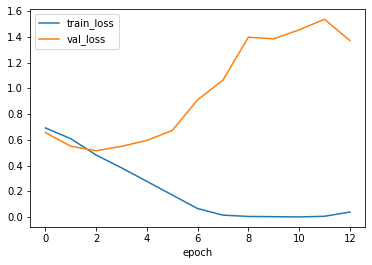

In [37]:
from matplotlib import pyplot as plt
loss = [[i, item['Training Loss'], item['Valid. Loss']] for i, item in enumerate(training_stats)]
acc = [[item["Best epoch"], 'Valid. Accur.'] for item in training_stats]

pd.DataFrame(loss, columns=["epoch", "train_loss","val_loss"]).set_index("epoch").plot(kind="line")
plt.show()

# 7. Train a model with all data for prediction


In [ ]:
batch_size = 32
emb_dim = vectors.size(-1)
seq_len = vectors.size(1)
num_filters = 64
kernel_sizes = [1, 3, 5]
num_labels = 2
labels = ['0','1']
class_weight = [1.0,1.0]

epochs = 5

result = []
X_train =  torch.tensor(vectors)
Y_train = torch.tensor(pd.get_dummies(df.label).values)

X_val =  torch.tensor(vectors[0:100])
Y_val = torch.tensor(pd.get_dummies(df.label).values[0:100])

# not needed. just to fulfill the traning function need
train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)  

train_dataloader = DataLoader(
    train_dataset,  # The training samples.
    sampler = RandomSampler(train_dataset), # Select batches randomly
    batch_size = batch_size # Trains with this batch size.
)

validation_dataloader = DataLoader(
    val_dataset, # The validation samples.
    sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
    batch_size = batch_size # Evaluate with this batch size.
)

model_name = '/content/drive/MyDrive/temp/bert_model/genbert_forpred_v2'
model = lstm_cnn(emb_dim, seq_len, 100, num_filters, kernel_sizes, num_labels)

model.to(device)
model, training_stats = train_single_label_model(model, num_labels, labels, train_dataloader, validation_dataloader, \
                                                         model_path = model_name, class_weight = class_weight,
                                                        optimizer=None, scheduler=None, \
                                                        epochs = epochs, patience = 8)
    


<ipython-input-38-00ff6d653c96>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train =  torch.tensor(vectors)
<ipython-input-38-00ff6d653c96>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val =  torch.tensor(vectors[0:100])


lstm_cnn(
  (lstm): LSTM(768, 100, batch_first=True, bidirectional=True)
  (convs): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(1, 200), stride=(1, 1))
    (1): Conv2d(1, 64, kernel_size=(3, 200), stride=(1, 1))
    (2): Conv2d(1, 64, kernel_size=(5, 200), stride=(1, 1))
  )
  (fc): Linear(in_features=192, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Epoch 1	 Train Loss: 0.6567	 Val Loss 0.5651	 Val Acc: 0.8100	 Val F1: 88.0503
model saved
Epoch 2	 Train Loss: 0.5071	 Val Loss 0.4252	 Val Acc: 0.8600	 Val F1: 91.1392
model saved
Epoch 3	 Train Loss: 0.3702	 Val Loss 0.1683	 Val Acc: 0.9300	 Val F1: 95.9064
model saved
Epoch 4	 Train Loss: 0.2547	 Val Loss 0.0982	 Val Acc: 0.9700	 Val F1: 98.2249
model saved
Epoch 5	 Train Loss: 0.1427	 Val Loss 0.0568	 Val Acc: 0.9900	 Val F1: 99.4083
model saved



# Predict sentences

In [ ]:
bert_pred = pd.read_csv('/content/drive/MyDrive/temp/raw_text_forbert.csv')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
bert_pred.head()

,text,encoded_unique_ticker_ts,rid
0,"Chun Hong, you're accusing DRAM of being high ...",new386,1
1,So you are talking about trending issue rather...,new386,2
2,What do you predict the -- I assume it will be...,new386,3
3,[indiscernible].,new386,4
4,That covers the cooling?,new386,5


In [ ]:
bert_pred.isnull().sum()

text                        30
encoded_unique_ticker_ts     0
rid                          0
dtype: int64

In [ ]:
bert_pred = bert_pred.dropna()

In [ ]:
bert_pred.shape

(4334161, 3)

In [ ]:
model_path= '/content/drive/MyDrive/temp/bert_model/genbert_forpred_v2'
emb_dim = 768
seq_len = 100
num_filters = 64
kernel_sizes = [1,3,5]
num_labels = 2
# labels = ['0','1']
# class_weight = [1.0, 1] 
    
the_model = lstm_cnn(emb_dim, seq_len, 100, num_filters, kernel_sizes, num_labels)
the_model.load_state_dict(torch.load(model_path))
the_model = the_model.to(device)
the_model.eval()

NameError: ignored

In [ ]:
conf_ids = bert_pred["encoded_unique_ticker_ts"].unique().tolist()
len(conf_ids)

59086

In [ ]:
target_file = '/content/drive/MyDrive/temp/predict_skp_gen_v3.csv' # manully change to v2
checkpoint = 0

if os.path.isfile(target_file):
  result = pd.read_csv(target_file)

  if len(bert_pred) >0:
    checkpoint = conf_ids.index(result["rid"].iloc[-1])
    checkpoint += 1
  else:
    result = pd.DataFrame([], columns = ["encoded_unique_ticker_ts","rid", "text", "predict"])
    result.to_csv(target_file, header=True, index = False)
else:
  result = pd.DataFrame([], columns = ["encoded_unique_ticker_ts","rid", "text", "predict"])
  result.to_csv(target_file, header=True, index = False)

print(checkpoint)

0


In [ ]:
result.shape

(0, 4)

In [ ]:
start = time.time()
batch_size  = 200

for cid in conf_ids[checkpoint:]:
  result = bert_pred[bert_pred.encoded_unique_ticker_ts==cid].copy()
  preds = []
  for i in range(0, len(result), batch_size):
    # get embedding
    x, masks = get_pretrained_wordvector(result["text"].iloc[i:(i+batch_size)], tokenizer, bert_model)
    x =  x * (masks.unsqueeze(-1).to(device))  ## 这里利用的是 broadcasting
    x = x.to(device)

    with torch.no_grad():
      pred = the_model(x)
      pred = torch.softmax(pred, dim = -1)
      pred = pred[:,-1].detach().cpu().numpy()

      preds.append(pred)
     
  result["predict"] = np.concatenate(preds, axis = 0)
  result.to_csv(target_file, header=False, index= False, mode='a')

  checkpoint += 1

  if checkpoint%100 ==0:
    print("{0}: {1: .2f}".format(checkpoint, time.time()-start))

100:  60.09
200:  129.33
300:  193.68
400:  263.03
500:  336.56
600:  407.21
700:  467.17
800:  532.67
900:  605.18
1000:  679.97
1100:  751.46
1200:  821.26
1300:  898.78
1400:  967.94
1500:  1034.39
1600:  1094.63
1700:  1164.98
1800:  1233.08
1900:  1299.02
2000:  1372.49
2100:  1448.78
2200:  1510.35
2300:  1571.87
2400:  1644.30
2500:  1721.94
2600:  1793.39
2700:  1857.26
2800:  1914.84
2900:  1985.78
3000:  2051.05
3100:  2127.33
3200:  2194.85
3300:  2268.47
3400:  2348.14
3500:  2423.26
3600:  2504.52
3700:  2582.12
3800:  2661.56
3900:  2739.55
4000:  2791.25
4100:  2858.62
4200:  2933.23
4300:  2993.49
4400:  3077.76
4500:  3143.23
4600:  3231.72
4700:  3343.22
4800:  3423.16
4900:  3494.86
5000:  3583.45
5100:  3654.80
5200:  3711.31
5300:  3782.93
5400:  3871.86
5500:  3928.04
5600:  3998.78
5700:  4086.70
5800:  4159.16
5900:  4239.75
6000:  4293.87
6100:  4351.97
6200:  4440.19
6300:  4506.91
6400:  4575.11
6500:  4652.71
6600:  4751.79
6700:  4816.54
6800:  4883.42
6900